# StackExchange Analysis #Clustering #Exploratory Analysis

In [1]:
# reading the xml files from the cwd

### Imports, functions and global variables
import sys
import os
import re
from bs4 import BeautifulSoup as Soup
from collections import Counter
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


totalquestions=0
totalQuestionswithacceptedanswers=0
totalQuestionswithnoacceptedanswers=0
bodydict=dict()

posts_by_tag = defaultdict()
tags_by_year = defaultdict()
tags_by_post_id = defaultdict()
userdict=dict()
tags=list()

acceptedanswers=list()
bestuser=list()

def populate_posts_by_tag(tag,post_id):
    global posts_by_tag
    if tag == '':
        return
    if post_id == '':
        return

    if tag not in posts_by_tag:
        posts_by_tag[tag] = set()
    posts_by_tag[tag].add(int(post_id))

def populate_tags_by_post_id(id,tag):
    global tags_by_post_id
    if tag == '':
        return
    if id == '':
        return

    if id not in tags_by_post_id:
        tags_by_post_id[id] = list()
    tags_by_post_id[id].append(tag)
    
def populate_tags_by_year(tag,year):
    global tags_by_year
    if tag == '':
        return
    if year == '':
        return

    if tag not in tags_by_year:
        tags_by_year[tag] = list()
    tags_by_year[tag].append(year)

def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/100 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(8,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i+0.5,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()
    
def parse_posts(file):
    global totalquestions,totalQuestionswithacceptedanswers,totalQuestionswithnoacceptedanswers,bodydict

    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            id = msg_attrs['id']     

            if 'tags' in msg_attrs:
                year =  msg_attrs['creationdate'].split("-")[0]
                #print(year)
                msg_attrs=(msg_attrs[u'tags'].replace('<','').replace('>',','))
                for msg in msg_attrs.split(','):
                    tags.append(msg)
                    populate_posts_by_tag(msg,id)
                    populate_tags_by_year(msg,year)
                    populate_tags_by_post_id(id,msg)
            
            msg_attrs = dict(message.attrs)
            posttypeid = msg_attrs['posttypeid']
            
            if posttypeid == "1":
                totalquestions+=1
                if 'body' in msg_attrs:
                    #id=(msg_attrs[u'id'])
                    body=(msg_attrs[u'body'])
                    bodydict[id]=Soup(body,"html.parser").getText()
                
                if 'acceptedanswerid' in msg_attrs:
                    totalQuestionswithacceptedanswers+=1
                    acceptedanswerid = msg_attrs['acceptedanswerid']
                    acceptedanswers.append(acceptedanswerid)
                else:
                    totalQuestionswithnoacceptedanswers+=1
            else:
                if id in acceptedanswers and 'owneruserid' in msg_attrs:
                     bestuser.append(msg_attrs['owneruserid'])
                    
                #count=count+1

            # if count == 5:
            #     break
            
def parse_users(file):
    global userdict
    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            id=(msg_attrs[u'id'])
            username=(msg_attrs[u'displayname'])
            userdict[id]=username                   

In [6]:
import os
path=os.path.join(os.getcwd(),'data', 'Posts.xml')
print(path)
parse_posts(path)

C:\Users\samym\Documents\GitHub\DataMiningCS6220\data\Posts.xml


In [15]:
import re
newbodydict=dict()
count=0
from textblob import TextBlob
for k,v in bodydict.items():
    blob = TextBlob(v)
    blob=set(blob.noun_phrases)
    blob=' '.join(blob)
    blob=re.sub('[^A-Za-z0-9 ]+', '', blob)
    newbodydict[k]=blob
    count+=1
    if count == 20000:
        break

print(len(newbodydict.keys()))

20000


In [7]:
print(len(bodydict.keys()))

42782


In [6]:
import nltk
#nltk.download()
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for k,v in newbodydict.items():
    allwords_stemmed = tokenize_and_stem(v)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(v)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
import pandas as pd

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.4, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(newbodydict.values())

print(tfidf_matrix.shape)

Wall time: 15.8 s
(20000, 386)


In [11]:
train_matrix=tfidf_matrix[:18000]
print(train_matrix.shape)

(18000, 386)


In [12]:
test_matrix=tfidf_matrix[18000:]
print(test_matrix.shape)

(2000, 386)


In [13]:
terms = tfidf_vectorizer.get_feature_names()
print (terms)

['abov', 'abstract', 'access', 'account', 'action', 'activ', 'actual', 'addit', 'address', 'agil', 'algorithm', 'altern', 'analysi', 'andor', 'android', 'api', 'app', 'applic', 'approach', 'appropri', 'architectur', 'area', 'argument', 'array', 'aspnet', 'b', 'background', 'bad', 'base', 'basic', 'big', 'bit', 'book', 'browser', 'bug', 'build', 'busi', 'busi logic', 'c', 'ca', 'ca nt', 'case', 'certain', 'chang', 'check', 'choic', 'class', 'client', 'code', 'code base', 'code review', 'command', 'comment', 'commerci', 'common', 'communic', 'compani', 'compil', 'complet', 'complex', 'compon', 'comput', 'concept', 'configur', 'connect', 'contain', 'content', 'control', 'core', 'correct', 'creat', 'css', 'current', 'custom', 'd', 'data', 'data structur', 'databas', 'day', 'db', 'decis', 'definit', 'depend', 'design', 'design pattern', 'desktop', 'dev', 'develop', 'differ', 'direct', 'document', 'doe', 'domain', 'duplic', 'dynam', 'easi', 'edit', 'effect', 'element', 'email', 'end', 'engin

In [21]:

from sklearn.cluster import KMeans

num_clusters = 10
km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=0)

%time km.fit(train_matrix)

clusters = km.labels_.tolist()

Wall time: 2.99 s


In [22]:
from sklearn import metrics
labels = km.labels_
metrics.silhouette_score(train_matrix, labels, metric='euclidean')

0.019167444840021385

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(train_matrix)

def runkmeans(n_clusters_end):
    i=2
    exp_k = i
    exp_sc = -1
    while i <= n_clusters_end:
        print(i)
        km1 = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1,
                    verbose=0)

        km1.fit(train_matrix) 
        labels = km1.labels_
        score=metrics.silhouette_score(train_matrix, labels, metric='euclidean')
        if score > exp_sc:
            exp_sc = score
            exp_k = i
        i+=1
    print(exp_k, exp_sc)

runkmeans(50)

In [24]:
postlist=list()
for k in newbodydict.keys():
    postlist.append(k)

#print(postlist)

In [25]:
import pandas as pd

Assignments = { 'post': postlist[:18000], 'cluster': clusters }

frame = pd.DataFrame(Assignments, index = [clusters] , columns = ['post', 'cluster'])

In [26]:
frame['cluster'].value_counts()


0    8789
8    2037
3    1810
6    1355
4    1277
9     917
1     726
2     539
7     328
5     222
Name: cluster, dtype: int64

In [27]:
clusterdict=dict()
from __future__ import print_function
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
#terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i]:
        print(' %s' % terms[ind], end='')
    print()
    print()
    
    print("Cluster %d Posts:" % i, end='')
    if type(frame.ix[i]['post']) != str:
        for post in frame.ix[i]['post'].values.tolist():
            print(' %s,' % post, end='')
            if i in clusterdict:
                clusterdict[i].append(post)
            else:
                clusterdict[i]=list(post)
            
    else:
        print(frame.ix[i]['post'])
    print() #add whitespace
    print() #add whitespace

Cluster 0: class data s user differ file function object good method new way test public java doe databas type time return nt thank string specif exampl use valu question number applic int problem edit multipl php server case version thing model api structur tabl current programm simpl app window need sql program basic control practic interfac right solut work librari comput real algorithm javascript m googl certain busi text logic python code inform idea reason process common updat id implement person void main client static store end list access bad approach framework level x separ page c product larg small oper domain key point variabl servic valid var standard privat general custom view result manag particular field unit possibl perform search big pleas input state layer line post html similar mvc document data structur b properti memori licens websit issu complex term requir various entiti actual thread design form event abstract ui technic duplic chang site long learn unit test d

In [28]:
predictedop=km.predict(test_matrix).tolist()
print(predictedop)

[6, 0, 0, 8, 6, 8, 3, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 9, 2, 0, 6, 0, 0, 3, 4, 3, 0, 0, 0, 9, 0, 0, 0, 0, 0, 8, 0, 0, 6, 0, 7, 8, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 2, 9, 0, 0, 3, 0, 4, 0, 0, 8, 0, 0, 6, 3, 4, 8, 1, 3, 0, 8, 0, 9, 0, 0, 0, 0, 6, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 4, 0, 7, 0, 3, 0, 7, 0, 8, 4, 0, 8, 0, 0, 4, 0, 0, 0, 9, 0, 0, 0, 0, 4, 6, 0, 4, 0, 8, 0, 0, 0, 9, 4, 8, 3, 0, 8, 0, 0, 1, 0, 0, 0, 9, 0, 0, 0, 3, 8, 0, 3, 4, 0, 8, 0, 0, 0, 0, 2, 4, 3, 0, 2, 0, 8, 4, 8, 0, 0, 0, 0, 9, 0, 4, 9, 3, 6, 0, 0, 0, 0, 0, 0, 4, 4, 8, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 8, 0, 0, 0, 6, 9, 0, 0, 0, 3, 0, 0, 3, 0, 8, 8, 6, 0, 8, 0, 0, 8, 7, 3, 1, 0, 9, 0, 2, 0, 5, 0, 0, 8, 3, 8, 0, 8, 0, 0, 0, 6, 0, 2, 8, 0, 6, 4, 0, 0, 6, 8, 8, 0, 4, 0, 3, 0, 8, 0, 0, 0, 4, 5, 3, 0, 0, 2, 9, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 0, 9, 0, 6, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 5, 0, 0, 0, 0, 1, 2, 8, 0, 0, 6, 8, 0, 0, 4, 8, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 4, 9, 6, 0, 0, 0, 0, 0, 8, 0, 0, 4, 7, 0, 0, 0, 0, 9, 

In [37]:
#1st element belongs to cluster 6
print(list(newbodydict.keys())[18001])
print(newbodydict.get(list(newbodydict.keys())[18001]))

188337
user editing stack overflow admin users cms site jquery magic think particular section unique id clean way  p  current plan wysiwyg alternative ways page loads user post wsgi


In [38]:
#21st element belongs to cluster 6
print(list(newbodydict.keys())[18021])
print(newbodydict.get(list(newbodydict.keys())[18021]))

188468
valuable thing classic way language research event listeners re problematic different parts easy unit large codebase dynamically large systems s blog post hairy flow yossi kreinin global data structure functionality needs distant code


In [ ]:
#post id  : (tags in posts.xml)
#188337 : wysiwyg grails
#188468 : architechture programming languages

In [29]:
X = tfidf_matrix.todense()

In [30]:
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=2).fit_transform(X)


In [31]:
print(reduced_data.shape)

(20000, 2)


In [32]:
labels = km.fit_predict(tfidf_matrix)

In [33]:
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'}
import matplotlib.pyplot as plt

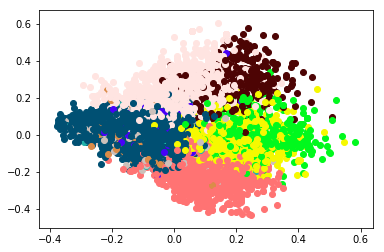

In [34]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance)
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

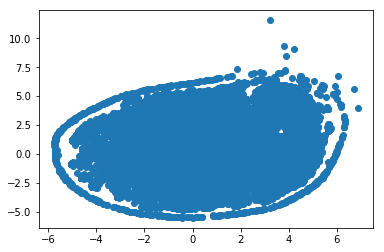

In [35]:
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

#### Exploratory analysis of users and questions on programmers.stackexchange.com 

In [11]:
path2=os.path.join(os.getcwd(),'data', 'Users.xml')
print(path2)
import json
parse_users(path2)   
path2=os.path.join(os.getcwd(),'preprocesseddata', 'users.txt')
file=open(path2,'w',encoding="UTF8")
json.dump(userdict, file)
file.close()

C:\Users\samym\Documents\GitHub\DataMiningCS6220\data\Users.xml


In [12]:
path2=os.path.join(os.getcwd(),'preprocesseddata', 'users.txt')
allusers= json.load(open(path2))
print("Total number of users: ", len(allusers))

Total number of users:  208279


In [13]:
print("Total Questions asked ", totalquestions)
print("Questions with accepted answers ", totalQuestionswithacceptedanswers)
print("Questions with no accepted answers ", totalQuestionswithnoacceptedanswers)

Total Questions asked  42782
Questions with accepted answers  25280
Questions with no accepted answers  17502


In [14]:
print("Top 20 Users with most accepted answers:")
for x,y in Counter(bestuser).most_common(20):
    print(allusers[x],":",y,"accepted answers")

Top 20 Users with most accepted answers:
Robert Harvey : 575 accepted answers
Doc Brown : 470 accepted answers
Arseni Mourzenko : 381 accepted answers
Bart van Ingen Schenau : 347 accepted answers
Karl Bielefeldt : 323 accepted answers
Kilian Foth : 248 accepted answers
Telastyn : 235 accepted answers
Thomas Owens : 232 accepted answers
amon : 213 accepted answers
GlenH7 : 210 accepted answers
gbjbaanb : 190 accepted answers
Jörg W Mittag : 170 accepted answers
pdr : 157 accepted answers
Mason Wheeler : 141 accepted answers
Ixrec : 129 accepted answers
Péter Török : 127 accepted answers
tdammers : 123 accepted answers
Michael Borgwardt : 121 accepted answers
Yannis : 119 accepted answers
Euphoric : 113 accepted answers


# Inspect top 20 tags for this data set.

Each post on the website can be associated with multiple tags, which classify the post into a broad topic/category.
By counting tag occurences, we determine the top 20 tags. This reflects the popularity of programming topics that users have questions about on the website.

In [4]:
tags=list(filter(None, tags))
counts=dict()

top_20_words = Counter(tags).most_common(20)
print("Top 20 most common tags, and the number of their occurences :", top_20_words)

Top 20 most common tags, and the number of their occurences : [('java', 3511), ('c#', 3007), ('design', 2886), ('design-patterns', 2475), ('object-oriented', 2036), ('c++', 1822), ('algorithms', 1732), ('php', 1667), ('architecture', 1639), ('javascript', 1578), ('licensing', 1269), ('database', 1256), ('web-development', 1223), ('programming-languages', 1205), ('python', 1183), ('programming-practices', 1167), ('.net', 1084), ('unit-testing', 1063), ('c', 958), ('testing', 956)]


# Visualization of the top 10 tags in the stackexchange data set.

[('java', 3511), ('c#', 3007), ('design', 2886), ('design-patterns', 2475), ('object-oriented', 2036), ('c++', 1822), ('algorithms', 1732), ('php', 1667), ('architecture', 1639), ('javascript', 1578)]


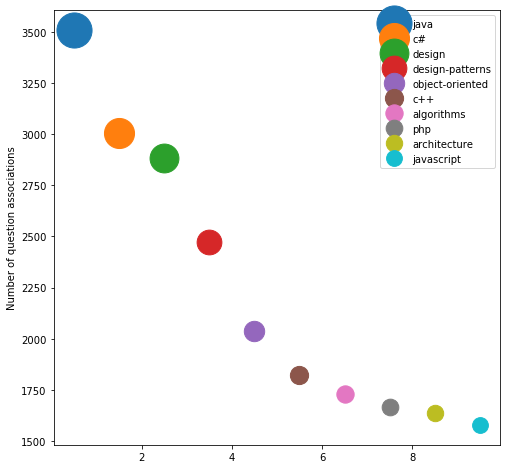

In [16]:
import collections
import numpy as np
tagCount =  collections.Counter(list(tags)).most_common(10)
print(tagCount)
plot_tags(tagCount)

#### Plot popularity of top 10 tags over recent years

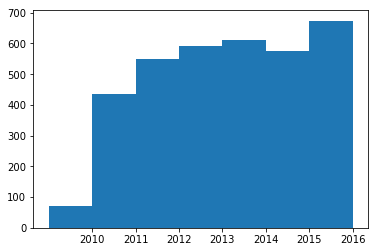

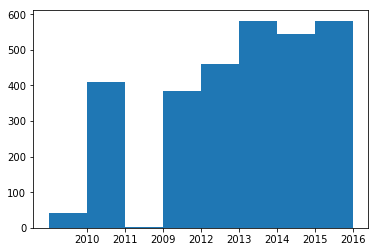

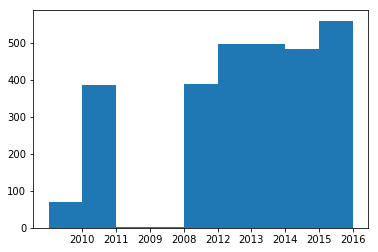

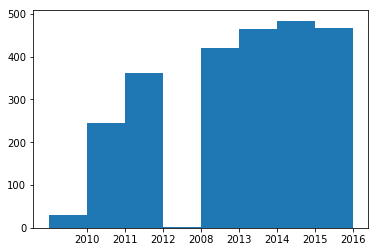

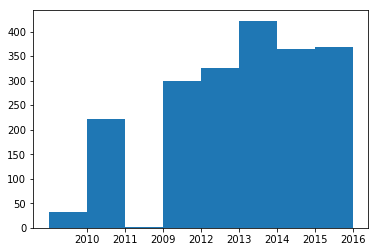

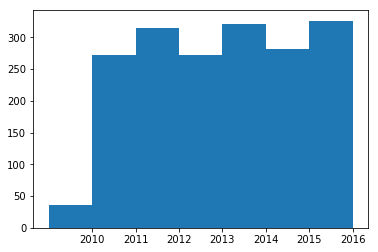

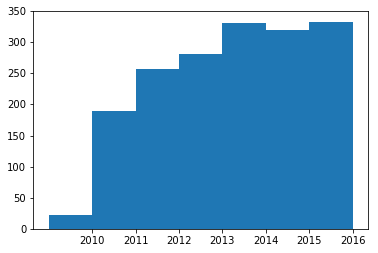

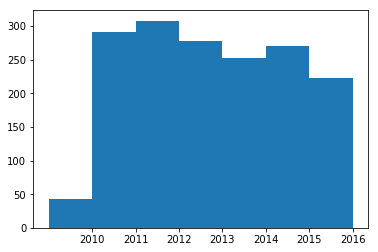

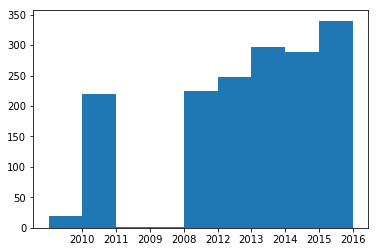

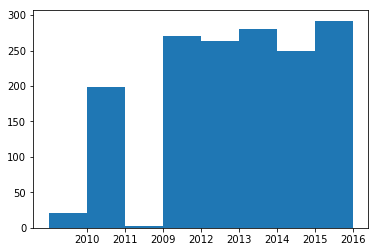

In [17]:
top_10_dict = dict()
for key in tagCount:
    top_10_dict[key[0]] = Counter(tags_by_year[key[0]])
    
for tag in top_10_dict:
    labels, values = zip(*top_10_dict[tag].items())
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()